In [109]:
# Suppression des warnings
import warnings
warnings.filterwarnings('ignore')

# Contexte :
L’analyse massive des données de santé a révolutionné le secteur médical, notamment en oncologie, en améliorant le pronostic et le traitement des maladies complexes comme le cancer. Les modèles prédictifs permettent des décisions thérapeutiques plus précises et adaptées, optimisant ainsi les soins aux patients.

Le **Data Challenge de QRT**, en collaboration avec l’Institut Gustave Roussy, vise à prédire le risque de décès des patients atteints d’une leucémie myéloïde adulte en utilisant des données cliniques et moléculaires. L’objectif est d’optimiser les stratégies thérapeutiques en identifiant les patients à haut ou faible risque, afin d’améliorer leur prise en charge.

Nous allons travailler sur un **jeu de données** comprenant des informations de 3 323 patients en entraînement et 1 193 en test, issues de 24 centres cliniques. Deux types de données sont exploitées :
- **Données cliniques** (ex. taux de globules blancs, hémoglobine, anomalies chromosomiques).
- **Données moléculaires** (mutations génétiques et impact sur les protéines).

L’évaluation repose sur l’**IPCW-C-index**, une métrique adaptée aux données censurées. Un **modèle de risques proportionnels de Cox** sert de benchmark, comparé à un modèle LightGBM plus simple. L’objectif final est de soumettre des prédictions de risque de décès sous forme de fichier CSV.

Dans le cadre du cours de **machine learning**, nous travaillons sur ce projet pour développer des modèles prédictifs et améliorer la compréhension des approches en analyse de survie.

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.impute import SimpleImputer

In [179]:
### Chargement des données train
Xtrain_clin = pd.read_csv("C:/Users/omaim/OneDrive/Bureau/Machine Learning/X_test/clinical_test.csv")
Xtrain_mol = pd.read_csv("C:/Users/omaim/OneDrive/Bureau/Machine Learning/X_test/molecular_test.csv")
Y_train = pd.read_csv("C:/Users/omaim/OneDrive/Bureau/Machine Learning/target_train.csv")

### Chargement des données test
Xtest_clin = pd.read_csv("C:/Users/omaim/OneDrive/Bureau/Machine Learning/X_test/clinical_test.csv")
Xtest_mol = pd.read_csv("C:/Users/omaim/OneDrive/Bureau/Machine Learning/X_test/molecular_test.csv")


In [162]:
print("Aperçu des données :")
print(Xtrain_clin.head())
print(Xtrain_mol.head())

Aperçu des données :
     ID CENTER  BM_BLAST    WBC     ANC  MONOCYTES    HB   PLT  \
0  KYW1    KYW      68.0   3.45  0.5865        NaN   7.6  48.0   
1  KYW2    KYW      35.0   3.18  1.2402        NaN  10.0  32.0   
2  KYW3    KYW       NaN  12.40  8.6800        NaN  12.3  25.0   
3  KYW4    KYW      61.0   5.55  2.0535        NaN   8.0  44.0   
4  KYW5    KYW       2.0   1.21  0.7381        NaN   8.6  27.0   

                                        CYTOGENETICS  
0                47,XY,+X,del(9)(q?)[15]/47,XY,+X[5]  
1  46,XY,der(3)?t(3;11)(q26.2;q23),add(4)(p15).de...  
2                                           47,XX,+8  
3                                             Normal  
4  43,XY,dic(5;17)(q11.2;p11.2),-7,-13,-20,-22,+r...  
       ID CHR       START         END REF ALT   GENE PROTEIN_CHANGE  \
0  KYW961   1   1747229.0   1747229.0   T   C   GNB1         p.K57E   
1  KYW142   1   1747229.0   1747229.0   T   C   GNB1         p.K57E   
2  KYW453   1   1747229.0   1747229.0  

# Données cliniques : 
- ID : Identifiant unique du patient.
- CENTER : Centre médical où le patient a été traité.
- BM_BLAST : Pourcentage de cellules blastiques dans la moelle osseuse (critère clé pour les leucémies).
- WBC : Nombre de globules blancs (White Blood Cell count).
- ANC : Nombre absolu de neutrophiles.
- MONOCYTES : Nombre de monocytes.
- HB : Niveau d’hémoglobine.
- PLT : Nombre de plaquettes sanguines.
- CYTOGENETICS : Anomalies cytogénétiques détectées.

# Données moléculaires
- ID : Identifiant unique du patient.
- CHR : Chromosome où la mutation a été détectée.
- START / END : Position génomique de la mutation.
- REF / ALT : Base de référence et base mutée.
- GENE : Nom du gène affecté.
- PROTEIN_CHANGE : Modification de la protéine codée.
- EFFECT : Effet de la mutation (non_synonymous_codon, stop_gained, etc.).
- VAF : Fréquence allélique de la mutation (proportion des copies de l’ADN affectées).
- DEPTH : Profondeur de lecture (nombre de fois que cette mutation a été détectée dans le séquençage).

In [163]:
print("Aperçu des données cible:")
print(Y_train.head())

Aperçu des données cible:
        ID  OS_YEARS  OS_STATUS
0  P132697  1.115068        1.0
1  P132698  4.928767        0.0
2  P116889  2.043836        0.0
3  P132699  2.476712        1.0
4  P132700  3.145205        0.0


# Variable cible (survie des patiencts)
- ID : 
- OS_YEARS : Durée de survie en années après le diagnostic.
- OS_STATUS : Statut de survie (0 = en vie, 1 = décédé).

In [164]:
print("Description statistique des données :")
print(Xtrain_clin.describe())
print(Xtrain_mol.describe())

Description statistique des données :
          BM_BLAST          WBC          ANC   MONOCYTES           HB  \
count  1078.000000  1081.000000  1052.000000  310.000000  1082.000000   
mean     12.966605     7.325801     2.978544    0.834611     8.823937   
std      17.277913    20.671223     6.478361    2.486857     2.264771   
min       0.000000     0.000000     0.000000    0.000000     2.700000   
25%       2.000000     1.850000     0.539850    0.058075     7.400000   
50%       6.000000     2.900000     1.296000    0.200750     8.400000   
75%      17.000000     5.300000     2.640000    0.408650    10.100000   
max      96.000000   338.100000    76.140600   25.267500    23.800000   

               PLT  
count  1078.000000  
mean    120.631633  
std     162.570156  
min       0.000000  
25%      37.000000  
50%      74.000000  
75%     143.000000  
max    2150.000000  
              START           END          VAF        DEPTH
count  3.020000e+03  3.020000e+03  3089.000000  3020.00

In [165]:
print("Analyse des valeurs manquantes :")
print(Xtrain_mol.isna().sum())
print(Xtrain_clin.isna().sum())

Analyse des valeurs manquantes :
ID                 0
CHR               69
START             69
END               69
REF               69
ALT               69
GENE               0
PROTEIN_CHANGE    46
EFFECT            90
VAF                0
DEPTH             69
dtype: int64
ID                0
CENTER            0
BM_BLAST        115
WBC             112
ANC             141
MONOCYTES       883
HB              111
PLT             115
CYTOGENETICS    116
dtype: int64


In [166]:
Xtrain_mol["ID"].value_counts()

ID
KYW791     14
KYW733     13
KYW201     13
KYW203     13
KYW202     11
           ..
KYW1083     1
KYW35       1
KYW170      1
KYW974      1
KYW18       1
Name: count, Length: 1054, dtype: int64

In [167]:
Xtrain_mol1 = Xtrain_mol.drop_duplicates(subset="ID", keep = False)

In [170]:
Xtrain_mol1["ID"].value_counts()

ID
KYW1048    1
KYW135     1
KYW430     1
KYW1076    1
KYW560     1
          ..
KYW746     1
KYW235     1
KYW969     1
KYW918     1
KYW18      1
Name: count, Length: 257, dtype: int64

In [181]:
#Merge la data VERIFIER NB ROWS PAR DATAFRAME
data_train = Xtrain_clin.merge(Xtrain_mol, on='ID', how = "left")

In [184]:
data_train

,ID,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
0,KYW1,68.0,3.45,0.5865,NaN,7.6,48.0,"47,XY,+X,del(9)(q?)[15]/47,XY,+X[5]",2,25467449.0,25467449.0,C,A,DNMT3A,p.G543C,non_synonymous_codon,0.3840,799.0
1,KYW1,68.0,3.45,0.5865,NaN,7.6,48.0,"47,XY,+X,del(9)(q?)[15]/47,XY,+X[5]",5,170837543.0,170837543.0,-,TCTG,NPM1,p.L287fs,frameshift_variant,0.2100,257.0
2,KYW1,68.0,3.45,0.5865,NaN,7.6,48.0,"47,XY,+X,del(9)(q?)[15]/47,XY,+X[5]",X,154301677.0,154301677.0,G,T,BRCC3,p.G56X,stop_gained,0.0270,586.0
3,KYW1,68.0,3.45,0.5865,NaN,7.6,48.0,"47,XY,+X,del(9)(q?)[15]/47,XY,+X[5]",NaN,NaN,NaN,NaN,NaN,FLT3,FLT3_ITD,ITD,0.3639,NaN
4,KYW2,35.0,3.18,1.2402,NaN,10.0,32.0,"46,XY,der(3)?t(3;11)(q26.2;q23),add(4)(p15).de...",1,115258747.0,115258747.0,C,T,NRAS,p.G12D,non_synonymous_codon,0.0720,848.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3223,KYW1192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,176939549.0,176939549.0,-,G,DDX41,p.P499fs,frameshift_variant,0.5070,456.0
3224,KYW1192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,176940748.0,176940748.0,C,T,DDX41,p.A346T,non_synonymous_codon,0.2030,404.0
3225,KYW1192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,148526910.0,148526910.0,G,A,EZH2,p.P132S,non_synonymous_codon,0.2070,662.0
3226,KYW1193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,112362360.0,112362360.0,G,C,SMC3,p.E1078D,non_synonymous_codon,0.4200,407.0


In [183]:
data_train = data_train.drop(columns = ["CENTER"])

In [125]:
#Fonction pour préparation de données
def clean_data(data, columns):
    data_cleaned = data.dropna(subset = columns)
    return data_cleaned

In [126]:
target_data = Y_train.dropna()
target_data

,ID,OS_YEARS,OS_STATUS
0,P132697,1.115068,1.0
1,P132698,4.928767,0.0
2,P116889,2.043836,0.0
3,P132699,2.476712,1.0
4,P132700,3.145205,0.0
...,...,...,...
3316,P121826,0.547945,0.0
3317,P121827,2.339726,0.0
3320,P121830,1.997260,0.0
3321,P121853,0.095890,1.0


In [127]:
#il faut regrouper en personnes ayant vécu 0 à 2 ans de 2ans à 4 ...
En_vie = target_data[target_data["OS_STATUS"]==1.0]
Mort = target_data[target_data["OS_STATUS"]==0.0]

En_vie = En_vie.drop(columns = ["OS_STATUS"])
Mort = Mort.drop(columns = ["OS_STATUS"])


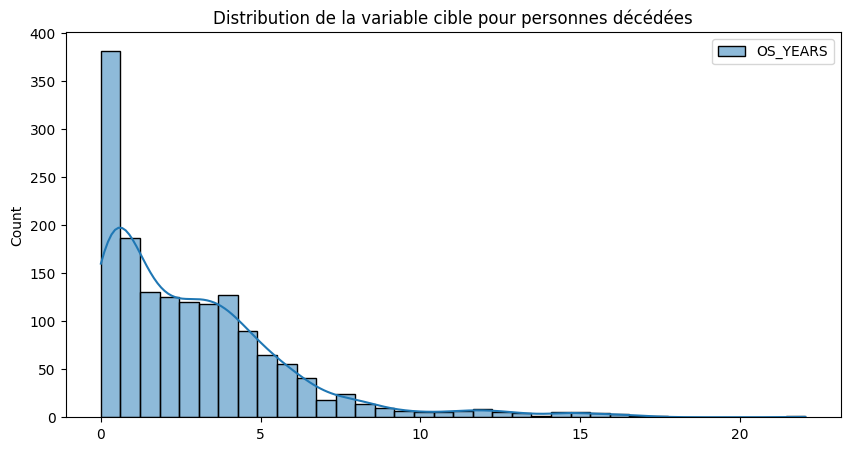

In [128]:
#Distribution de la variable cible
plt.figure(figsize=(10, 5))
sns.histplot(Mort, kde=True)
plt.title("Distribution de la variable cible pour personnes décédées")
plt.show()


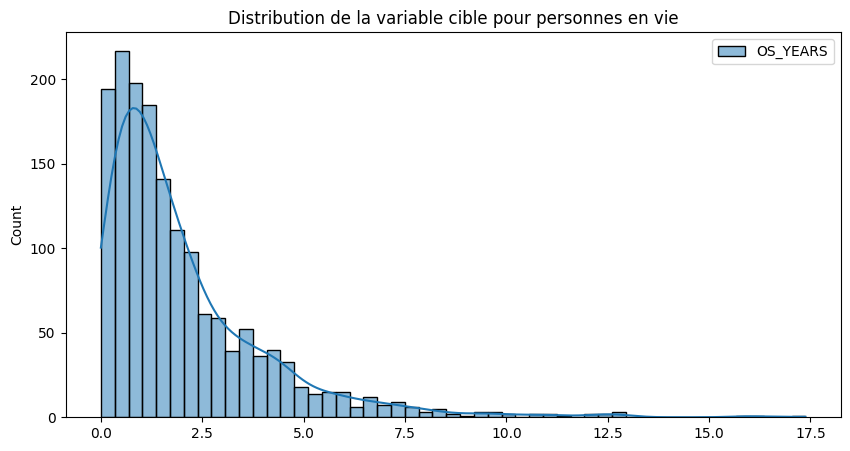

In [129]:
#Distribution de la variable cible
plt.figure(figsize=(10, 5))
sns.histplot(En_vie, kde=True)
plt.title("Distribution de la variable cible pour personnes en vie")
plt.show()

In [ ]:
data_train.CYTOGENETICS.dropna().value_counts()

CYTOGENETICS
Normal                                                                                                                                                                                      752
46,XX                                                                                                                                                                                        62
46,XY[21]                                                                                                                                                                                    55
46,XY                                                                                                                                                                                        54
46,XY[20]                                                                                                                                                                                    40
                           

In [192]:
def extract_sex(cytogenetics):
    if pd.isna(cytogenetics):
        return "Unknown"
    elif "46,XX" in cytogenetics:
        return "Female"
    elif "46,XY" in cytogenetics:
        return "Male"
    else:
        return "Unknown"

In [193]:
data_train["SEX"] = data_train["CYTOGENETICS"].apply(extract_sex)
print(data_train["SEX"].value_counts())

SEX
Unknown    1623
Male       1146
Female      459
Name: count, dtype: int64


In [202]:
data_train[data_train["SEX"]=="Male"]

,ID,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH,SEX
4,KYW2,35.0,3.18,1.2402,0.2280,10.0,32.0,"46,XY,der(3)?t(3;11)(q26.2;q23),add(4)(p15).de...",1,115258747.0,115258747.0,C,T,NRAS,p.G12D,non_synonymous_codon,0.072,848.0,Male
5,KYW2,35.0,3.18,1.2402,0.2280,10.0,32.0,"46,XY,der(3)?t(3;11)(q26.2;q23),add(4)(p15).de...",12,112888189.0,112888189.0,G,A,PTPN11,p.E69K,non_synonymous_codon,0.058,816.0,Male
6,KYW2,35.0,3.18,1.2402,0.2280,10.0,32.0,"46,XY,der(3)?t(3;11)(q26.2;q23),add(4)(p15).de...",X,39931853.0,39931853.0,T,A,BCOR,p.K916X,stop_gained,0.713,435.0,Male
19,KYW7,2.0,6.90,5.2095,0.2280,7.5,94.0,"46,XY,del(11)(q?)",17,7578272.0,7578272.0,G,A,TP53,p.H193Y,non_synonymous_codon,0.390,487.0,Male
20,KYW7,2.0,6.90,5.2095,0.2280,7.5,94.0,"46,XY,del(11)(q?)",21,44514777.0,44514777.0,T,G,U2AF1,p.Q157P,non_synonymous_codon,0.364,439.0,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3181,KYW1175,7.0,2.60,0.9620,0.5070,6.7,86.0,"46,XY,inv(11)(p15q22)[1]/46,XY[19]",2,198266834.0,198266834.0,T,C,SF3B1,p.K700E,non_synonymous_codon,0.338,385.0,Male
3182,KYW1175,7.0,2.60,0.9620,0.5070,6.7,86.0,"46,XY,inv(11)(p15q22)[1]/46,XY[19]",21,36231774.0,36231774.0,G,A,RUNX1,p.R204X,stop_gained,0.712,753.0,Male
3183,KYW1176,15.0,3.50,1.5960,0.2555,7.8,50.0,"45,XY,add(3)(p11),-4,add(6)(p21),del(9)(q?),-1...",17,7578403.0,7578403.0,C,T,TP53,p.C176Y,non_synonymous_codon,0.828,739.0,Male
3184,KYW1176,15.0,3.50,1.5960,0.2555,7.8,50.0,"45,XY,add(3)(p11),-4,add(6)(p21),del(9)(q?),-1...",4,106157809.0,106157809.0,C,T,TET2,p.Q904X,stop_gained,0.074,403.0,Male


In [ ]:
#Traitement valeurs manquantes si homme femme ou unknown imputer mediane

cols_to_impute = ['BM_BLAST', 'HB', 'PLT', 'ANC', 'WBC', 'MONOCYTES', 'DEPTH', 'VAF']

# Fonction pour imputer en utilisant la médiane par groupe
def impute_by_group(df, group_col, cols):
    imputed_df = df.copy()
    for group in df[group_col].unique():
        group_median = df[df[group_col] == group][cols].median()  
        imputed_df.loc[df[group_col] == group, cols] = df[df[group_col] == group][cols].fillna(group_median)
    return imputed_df

data_train = impute_by_group(data_train, "SEX", cols_to_impute)

In [207]:
missing_ratio = data_train.isna().mean() 
cols_to_drop = missing_ratio[missing_ratio > 0.5].index.tolist()
data_train = data_train.drop(columns = cols_to_drop)
data_train


,ID,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH,SEX
0,KYW1,68.0,3.45,0.5865,0.228,7.6,48.0,"47,XY,+X,del(9)(q?)[15]/47,XY,+X[5]",2,25467449.0,25467449.0,C,A,DNMT3A,p.G543C,non_synonymous_codon,0.3840,799.0,Unknown
1,KYW1,68.0,3.45,0.5865,0.228,7.6,48.0,"47,XY,+X,del(9)(q?)[15]/47,XY,+X[5]",5,170837543.0,170837543.0,-,TCTG,NPM1,p.L287fs,frameshift_variant,0.2100,257.0,Unknown
2,KYW1,68.0,3.45,0.5865,0.228,7.6,48.0,"47,XY,+X,del(9)(q?)[15]/47,XY,+X[5]",X,154301677.0,154301677.0,G,T,BRCC3,p.G56X,stop_gained,0.0270,586.0,Unknown
3,KYW1,68.0,3.45,0.5865,0.228,7.6,48.0,"47,XY,+X,del(9)(q?)[15]/47,XY,+X[5]",NaN,NaN,NaN,NaN,NaN,FLT3,FLT3_ITD,ITD,0.3639,493.0,Unknown
4,KYW2,35.0,3.18,1.2402,0.228,10.0,32.0,"46,XY,der(3)?t(3;11)(q26.2;q23),add(4)(p15).de...",1,115258747.0,115258747.0,C,T,NRAS,p.G12D,non_synonymous_codon,0.0720,848.0,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3223,KYW1192,8.0,3.10,1.3200,0.228,8.3,76.0,NaN,5,176939549.0,176939549.0,-,G,DDX41,p.P499fs,frameshift_variant,0.5070,456.0,Unknown
3224,KYW1192,8.0,3.10,1.3200,0.228,8.3,76.0,NaN,5,176940748.0,176940748.0,C,T,DDX41,p.A346T,non_synonymous_codon,0.2030,404.0,Unknown
3225,KYW1192,8.0,3.10,1.3200,0.228,8.3,76.0,NaN,7,148526910.0,148526910.0,G,A,EZH2,p.P132S,non_synonymous_codon,0.2070,662.0,Unknown
3226,KYW1193,8.0,3.10,1.3200,0.228,8.3,76.0,NaN,10,112362360.0,112362360.0,G,C,SMC3,p.E1078D,non_synonymous_codon,0.4200,407.0,Unknown


Variables non utile pour le modèle :

-  CHR, START, END : La position seule n’indique pas l’impact biologique de la mutation. Ce qui est vraiment utile, c’est le gène affecté et l’effet de la mutation (déjà fourni par les variables GENE et EFFECT).
Ce sont des variables très spécifiques qui risquent d’être trop granulaires pour un modèle de ML (car des milliers de positions peuvent exister). On pourrait toutefois les regrouper en secteurs.

- CENTER : Le centre médical n'est pas pertinente pour répondre à la problématique : évaluer le risque de décès pour les patients diagnostiqués avec un cancer du sang.
On peut toutefois vérifier s'il existe une différence significatives concernant les compétences/qualités des cliniques, qui impacteraient le risque de décès.

Variables utiles  :
Ces variables donnent des informations sur l’état physiologique du patient et peuvent être de bons indicateurs du risque de décès.

* BM_BLAST : Indicateur clé de la proportion de cellules sanguines anormales dans la moelle osseuse. Un taux élevé est souvent associé à une maladie plus agressive et un pronostic plus défavorable.

* WBC (Globules blancs) : Peut refléter la gravité de la maladie ; une élévation anormale peut être associée à un risque accru de complications.

* ANC (Neutrophiles absolus) : Essentiel pour évaluer l'état du système immunitaire et les risques d’infections opportunistes.

* MONOCYTES : Un taux élevé de monocytes peut être associé à une inflammation chronique et à une progression plus rapide de la maladie.

* HB (Hémoglobine) : Un faible taux d’hémoglobine est un marqueur d’anémie, souvent observé dans les cancers du sang avancés.

* PLT (Plaquettes) : Une thrombocytopénie (faible nombre de plaquettes) peut être associée à un mauvais pronostic, car elle peut entraîner des complications hémorragiques.

* CYTOGENETICS : Les anomalies chromosomiques sont souvent des indicateurs de l’agressivité du cancer. Par exemple, la monosomie 7 est un marqueur de haut risque.

On vérifie la granularité des colonnes (confirmer la supression des colonnes de positions de la mutations):
- START à 4645 valeurs distinctes
- END a 4664 vlaures disctinctes
- CHR possède 23 données.

On remarque également qu'il n'y a que 3'026 ID distincts pour plus de 10'000 lignes dans le dateset molecular_train, ce qui signifie que certains patient ont plusieurs mutations génétiques.

Il peut donc être pertinent de synthétiser les informations de ce dataset pour ne posséder qu'une ligne par ID. En effet, il ne faut pas faire une analyse par mutation mais une analyse par patient.

On peut créer une variable qui stock le nombre total de mutations par patients, cela pourrait améliorer la mesure de risque. 



In [131]:
data_train.nunique()

ID                1193
CENTER               1
BM_BLAST            82
WBC                458
ANC                937
MONOCYTES          271
HB                 119
PLT                321
CYTOGENETICS       708
CHR                 22
START             1534
END               1528
REF                140
ALT                 81
GENE                83
PROTEIN_CHANGE    1589
EFFECT               8
VAF                791
DEPTH             1041
dtype: int64

CYTOGENETICS : Les anomalies chromosomiques sont souvent des indicateurs de l’agressivité du cancer. Par exemple, la monosomie 7 est un marqueur de haut risque.

Or il y'a plus de 1194 données différents pour 2936 valeurs, (3223-2936 == NA).

In [133]:
data_train["ID"].value_counts()

ID
KYW791    14
KYW203    13
KYW733    13
KYW201    13
KYW202    11
          ..
KYW221     1
KYW551     1
KYW554     1
KYW555     1
KYW304     1
Name: count, Length: 1193, dtype: int64

In [134]:
Xtrain_clin["ID"].value_counts()
Xtrain_mol["ID"].value_counts() #dans mol il y a des id qui se répètent

ID
KYW791     14
KYW733     13
KYW201     13
KYW203     13
KYW202     11
           ..
KYW955      2
KYW38       2
KYW1023     2
KYW184      2
KYW483      2
Name: count, Length: 797, dtype: int64

In [175]:
target_data["ID"].value_counts()

ID
P132697    1
P120833    1
P120866    1
P120852    1
P120858    1
          ..
P110864    1
P110865    1
P110866    1
P110867    1
P121834    1
Name: count, Length: 3173, dtype: int64

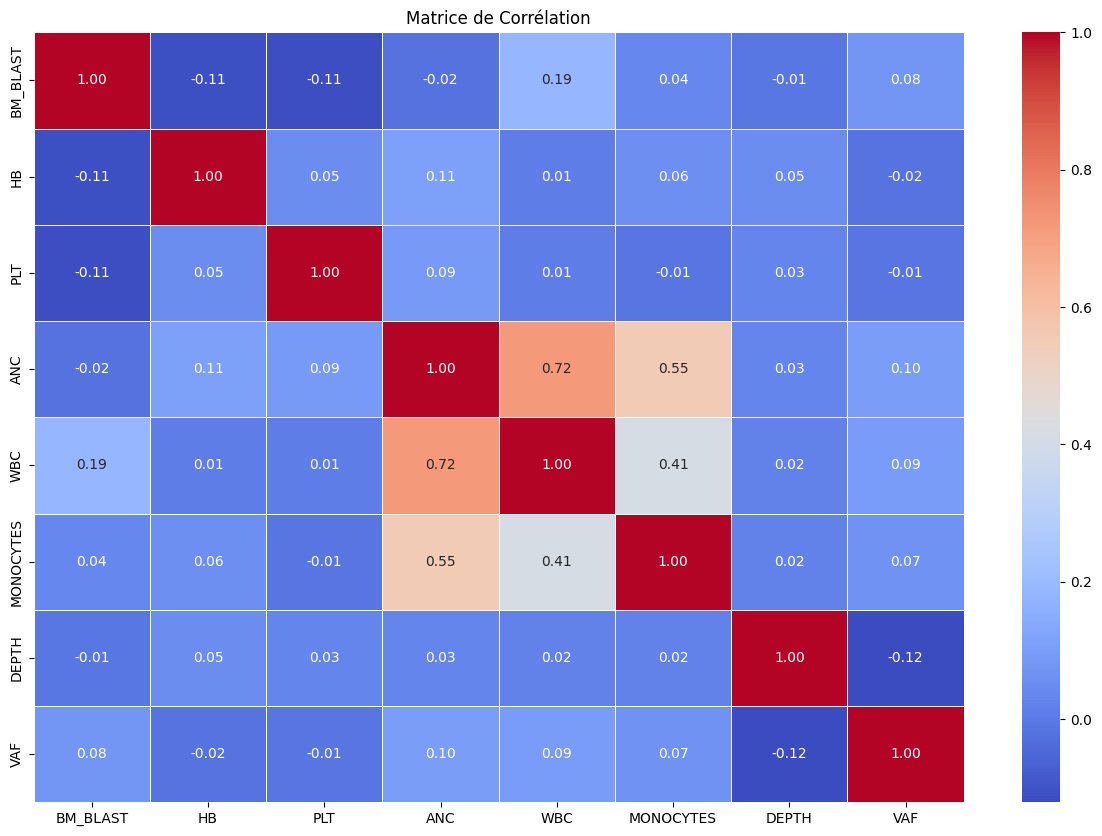

In [216]:
cols = ['BM_BLAST', 'HB', 'PLT', 'ANC', 'WBC', 'MONOCYTES', 'DEPTH', 'VAF']

correlation_matrix = data_train[cols].corr()


plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation")
plt.show()

On veut rattacher les deux dataframe pour n'en créer qu'un seul, on utilisera les clés uniques : "ID".
Dans le dataframe molecule train, on a plus de dis milles lignes. Alors qu'il n'yen a que 3323 dans le dataframe clinical train.
Celles dont l'ID n'est pas inclus dans clinical train seront supprimés.

À traiter : 
• Duplicated observations

• Missing data

• Heterogeneity in data reporting conventions: frequency of observations, units, date format, missing data representation, ... 

• Inconsistencies between databases

• ...

Some rules:

• Get acquainted with the data to get a better understanding of what they represent and understand the way they are encoded


• Perform exploratory analyses: number of observations, number of  missing values, the average value of features, median, standard deviation, inter-quartile range, binning/clustering correlations, ...

• Objective: identification of useful features, outliers, ...

Data cleaning :

• Missing data handling: deletion or imputation

• Duplicated data: techniques for deduplicating data

• Handling of outliers: deletion, winsorization

• Inconsistencies: partially automatic detection is made possible through functional dependencies (e.g. a city must always have the same zip code)

Data transformation :

• Feature scaling: some ML algorithms do not perform well when the input numerical attributes display very different scales, e.g. revenue vs. ratio. Normalization and standardization are two common ways to get all attributes to have the same scale Aggregation: e.g. cumulate daily data to transform them into monthly data

• Features construction: addition or replacement of some features by new features computed from existing ones (e.g. log transformation or power transformation to capture non-linearities)

• Discretization: the transformation of numerical values into classes